In [1]:
from ast import literal_eval
import numpy as np
from atmos_cloud_sim_uj_utils import show_plot
from matplotlib import pyplot
from joblib import Parallel, delayed

In [2]:
import os
os.environ["NUMBA_NUM_THREADS"] = "1"

In [3]:
from PySDM.physics import si
from PySDM.initialisation import discretise_multiplicities, equilibrate_wet_radii
from PySDM.initialisation.spectra import Lognormal, Sum
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity
from PySDM.backends import CPU
from PySDM.dynamics import AmbientThermodynamics, Condensation
from PySDM.environments import Parcel
from PySDM import Builder, Formulae, products

In [4]:
kappa_1 = .3

In [21]:
def run(**args):
    env = Parcel(
        dt = 10 * si.s,
        mass_of_dry_air = 1e3 * si.kg,
        p0 = 1000 * si.hPa,
        q0 = 20 * si.g / si.kg,
        T0 = args["T0"],
        w = .5 * si.m / si.s
    )
    modes = {
        kappa_1: Lognormal(norm_factor = 100.0 / si.mg, m_mode = 50.0 * si.nm,  s_geom = 2.0),
        .4: Lognormal(norm_factor = args["norm_factor_2"], m_mode = 50.0 * si.nm, s_geom = 2.0)
    }
    cloud_range = (.5 * si.um, 25 * si.um)
    n_steps = 500
    n_sd_per_mode = 50
    
    n_sd = len(modes) * n_sd_per_mode
    builder = Builder(backend=CPU(), n_sd=n_sd)
    builder.set_environment(env)
    builder.add_dynamic(AmbientThermodynamics())
    builder.add_dynamic(Condensation())

    attributes = {
        attr: np.empty(n_sd) for attr in (
            'volume', 'n', 'dry volume', 'kappa times dry volume'
        )
    }
    for mode, (kappa, spectrum) in enumerate(modes.items()):
        r_dry, specific_concentration = ConstantMultiplicity(spectrum).sample(n_sd_per_mode)
        v_dry = builder.formulae.trivia.volume(radius=r_dry)
        r_wet = equilibrate_wet_radii(r_dry, env, kappa * v_dry)

        chunk = slice(mode * n_sd_per_mode, (mode+1) * n_sd_per_mode)
        attributes['n'][chunk] = specific_concentration * env.mass_of_dry_air
        attributes['dry volume'][chunk] = v_dry
        attributes['kappa times dry volume'][chunk] = kappa * v_dry
        attributes['volume'][chunk] = builder.formulae.trivia.volume(radius=r_wet)

    r_bins_edges = np.linspace(0 * si.nm, 4e3 * si.nm, 101, endpoint=True)
    particulator = builder.build(attributes, products=())
    particulator.run(steps=n_steps)
    
    final_values = {}
    for attr in ('kappa', 'n', 'critical volume', 'volume'):
        final_values[attr] = particulator.attributes[attr].to_ndarray()
    
    
    activated_fraction = {}
    for kappa in modes.keys():
        within_mode = final_values['kappa'] == kappa
        activated_fraction[kappa] = (
            np.sum(np.where(
                np.logical_and(final_values['volume'] > final_values['critical volume'], within_mode),
                final_values['n'],
                0
            ))
            / 
            np.sum(np.where(
                within_mode,
                final_values['n'],
                0
            ))
        )
    
    return (str(args), activated_fraction)

In [18]:
data = Parallel(verbose=10, n_jobs=-1)(
    delayed(run)(**{'norm_factor_2': norm_factor_2, 'T0': T0})
        for norm_factor_2 in np.linspace(100, 5000/si.mg, 5)
        for T0 in (294 * si.K,)
)
data = dict(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   22.1s remaining:   33.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.3s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.1s finished


In [19]:
N_2_obs = [18.74716810149539, 110.41572270049846, 416.00589034889026, 918.1014952424102, 1914.816492976891, 4919.913910285455]
N_act_obs = [0.7926937018577255, 0.7161078386950611, 0.5953670140462167, 0.4850589034888989, 0.34446080652469424, 0.162630267331219]
N_2_paper_param = [54.6839601268689, 72.69483461712753, 109.48119619392855, 127.7469415496148, 155.44290892614436, 183.2238332578163,
                   220.2650657000454, 275.8269143633893, 312.86814680561884, 368.5999093792484, 433.50702310829183, 554.4007702763934,
                   628.9080199365658, 693.9850475758949, 740.5414589941097, 787.0129134571821, 852.3448119619393, 917.4218396012684,
                   973.3235160851837, 1047.915722700498, 1103.8173991844137, 1178.2396918894428, 1234.1413683733576,1280.7827367467153,
                   1364.5502945174449,1467.1782963298592,1513.734707748075, 1560.2911191662893, 1709.5604893520617, 1765.547122791119,
                   1849.4845944721342, 1989.408699592207, 2092.0367014046215, 2157.3685999093796, 2222.7004984141367, 2297.292705029451,
                   2353.364295423651, 2456.07725419121, 2549.2750339827826, 2605.26166742184, 2689.199139102854, 2810.6026280018123,
                   2997.3380154055285, 3099.8810602628, 3221.2845491617572, 3314.6522428636154, 3389.2444494789315, 3463.9216130493887,
                   3566.634571816946, 3650.657000453103, 3762.5453103760756, 3827.9621658359765, 3911.814680561849, 3995.922066153149,
                   4126.585863162664, 4247.904395106479, 4322.496601721793, 4397.258722247395, 4490.54145899411, 4574.563887630267,
                   4667.9315813321255, 4835.891481649297]
N_act_paper_param = [0.7307884005437245, 0.7016538287267784, 0.676110104213865, 0.657884005437245, 0.643271409152696, 0.6322949705482556,
                     0.6176597190756684, 0.5957068418667876, 0.5810715903942004, 0.5663910285455369, 0.5444154961486181, 0.5186678749433621,
                     0.5075781603987314, 0.49287494336202997, 0.48548935206162214, 0.4744676030811056, 0.47067285908473044, 0.45596964204802903,
                     0.4485613955595833, 0.4411078386950612, 0.43369959220661536, 0.41897371998187594, 0.4115654734934301, 0.4078160398731311,
                     0.39306751246035343, 0.3855459900317173, 0.37816039873130947, 0.37077480743090174, 0.3595038513819666, 0.3557317625736294,
                     0.3482555505210695, 0.33700724966017237, 0.32948572723153613, 0.325690983235161, 0.32189623923878585, 0.31444268237426376,
                     0.31430675124603535, 0.31042138649750806, 0.2992863615768011, 0.2955142727684641, 0.2880380607159041, 0.28410738559130055,
                     0.27638196647032176, 0.265224286361577, 0.2612936112369735, 0.25743090167648397, 0.249977344811962, 0.24615994562754873,
                     0.24227458087902143, 0.23843452650657015, 0.22725419120978696, 0.22709560489352065, 0.21598323516085194, 0.21577933846850939,
                     0.2081898504757591, 0.20062301767104684, 0.19316946080652464, 0.19298821930222032, 0.1854893520616221, 0.18164929768917082,
                     0.17778658812868153, 0.16647032170367027]


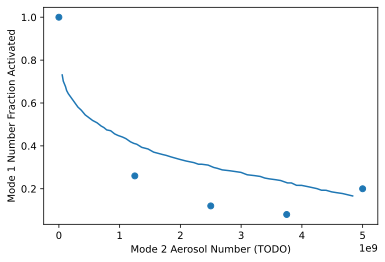

HTML(value="<a href='./fig_1.pdf' target='_blank'>./fig_1.pdf</a><br>")

In [20]:
pyplot.scatter(
    [literal_eval(key)['norm_factor_2'] for key in data.keys()],
    [np.nanmax(val[kappa_1]) for val in data.values()]
)
pyplot.plot(np.array(N_2_paper_param) / si.cm**3, N_act_paper_param)
pyplot.ylabel('Mode 1 Number Fraction Activated')
pyplot.xlabel('Mode 2 Aerosol Number (TODO)')
show_plot("fig_1.pdf")